In [127]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


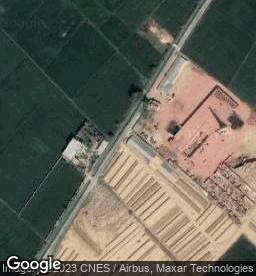

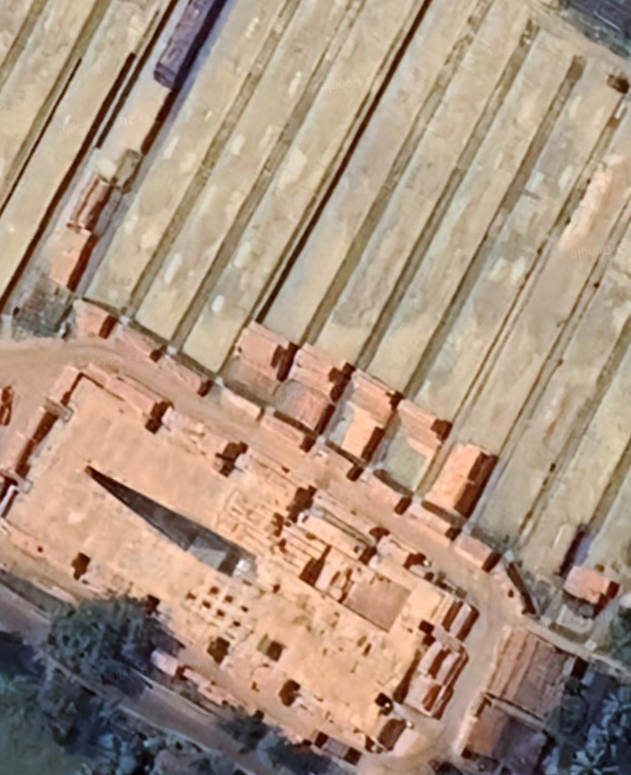

In [138]:
img_path = "/home/rishabh_mondal/brick_klins/india_bk/kiln_2 (1).png"
img_path1 = "/home/rishabh_mondal/brick_klins/68.png"

display(Image(img_path))
display(Image(img_path1))

In [139]:
model = ResNet50(weights='imagenet')
# model.summary()

In [140]:
# model_builder=keras.applications.xception.Xception
img_size=(224,224)
preprocess_input=keras.applications.xception.preprocess_input
decode_predictions=keras.applications.xception.decode_predictions


Functions to format image and create the Grad-CAM heatmap

In [141]:
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [142]:
last_conv_layer_name = "conv5_block3_3_conv"


Predicted: [('n01930112', 'nematode', 6.5061455)]


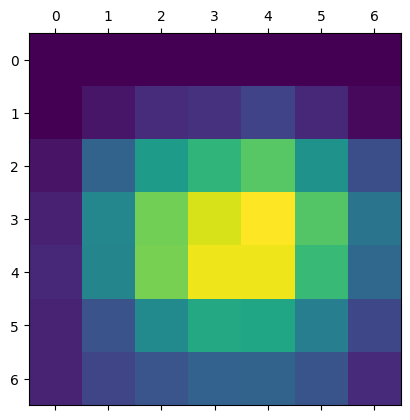

In [134]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))
model.layers[-1].activation = None
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

Predicted: [('n04153751', 'screw', 6.0754676)]


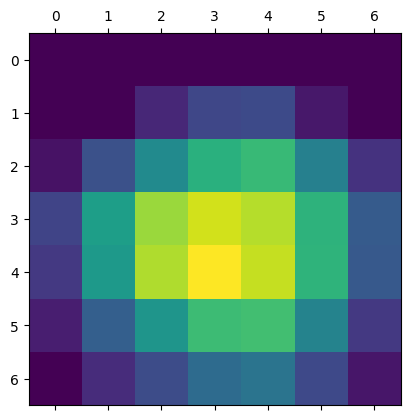

In [144]:
img_array = preprocess_input(get_img_array(img_path1, size=img_size))
model.layers[-1].activation = None
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])
heatmap1 = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)

/tmp/ipykernel_174864/3161549235.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


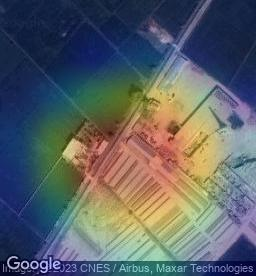

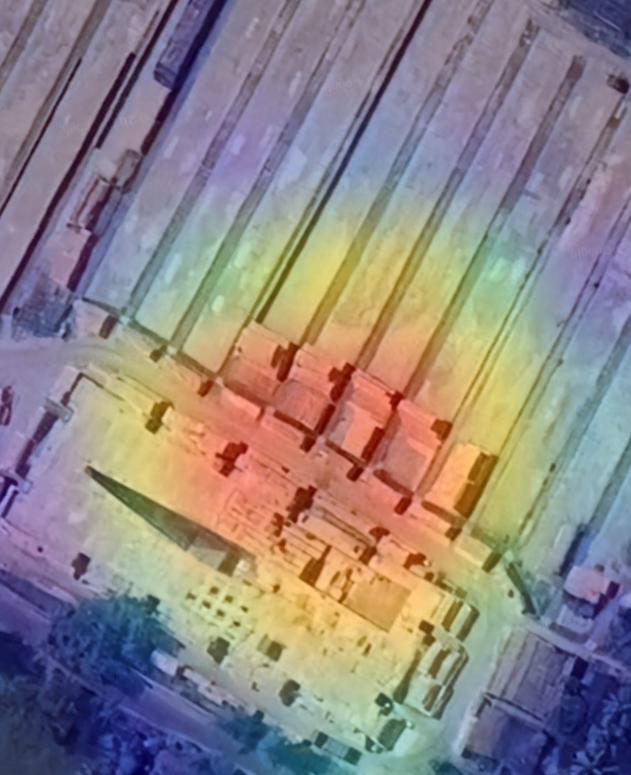

In [145]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)
save_and_display_gradcam(img_path1, heatmap1)